In [1]:
import os
os.environ["TF_NUM_THREADS"] = "0" # use all available CPU cores

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import xarray as xr
import pandas as pd
import time

import diffxpy as de
from batchglm.api.models.nb_glm import Simulator

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.WARNING)
logging.getLogger("diffxpy").setLevel(logging.WARNING)

logger = logging.getLogger(__name__)


In [2]:
def test_wilcoxon(sim):
    logger.info("test_wilcoxon started")
    start = time.time()
    test = de.test_pairwise(
        data=sim.X,
        grouping="batch",
        test="wilcoxon",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_wilcoxon finished in %fs", (end - start))

    return test, (end - start)


def test_t_test(sim):
    logger.info("test_t_test started")
    start = time.time()
    test = de.test_pairwise(
        data=sim.X,
        grouping="batch",
        test="t_test",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_t_test finished in %fs", (end - start))

    return test, (end - start)


def test_lrt(sim):
    logger.info("test_lrt started")
    start = time.time()
    test = de.test_pairwise(
        data=sim.X,
        grouping="batch",
        test="lrt",
        noise_model="nb",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_lrt finished in %fs", (end - start))

    return test, (end - start)


def test_wald(sim):
    logger.info("test_wald started")
    start = time.time()
    test = de.test_pairwise(
        data=sim.X,
        grouping="batch",
        test="wald",
        noise_model="nb",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_wald finished in %fs", (end - start))

    return test, (end - start)


def test_ztest(sim):
    logger.info("test_ztest started")
    start = time.time()
    test = de.test_pairwise(
        data=sim.X,
        grouping="batch",
        test="z-test",
        noise_model="nb",
        sample_description=sim.sample_description,
    )
    end = time.time()
    logger.info("test_ztest finished in %fs", (end - start))

    return test, (end - start)



In [3]:
df = pd.DataFrame(columns=[
    "n_groups",
    "n_cells",
    "n_genes",
    "wilcoxon",
    "t_test",
    # "lrt",
    "wald",
    "ztest",
])

n_groups = 4
n_genes = 1000
for n_cells in (1e3, 1e4, 1e5):
    n_cells = int(n_cells)
    logger.info("Running tests with n_cells=%d and n_genes=%d", n_cells, n_genes)
    
    sim = Simulator(num_observations=n_cells, num_features=n_genes)
    sim.generate_sample_description(num_batches=n_groups, num_confounders=0)
    sim.generate()

    df = df.append({
        "n_groups": n_groups,
        "n_cells": n_cells,
        "n_genes": n_genes,
        "wilcoxon": test_wilcoxon(sim)[1],
        "t_test": test_t_test(sim)[1],
        # "lrt": test_lrt(sim)[1],
        "wald": test_wald(sim)[1],
        "ztest": test_ztest(sim)[1],
    }, ignore_index=True)


Running tests with n_cells=1000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 1.659694s
test_t_test started
test_t_test finished in 0.052794s
test_wald started
test_wald finished in 44.985932s
test_ztest started
test_ztest finished in 14.055757s
Running tests with n_cells=10000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 5.965725s
test_t_test started
test_t_test finished in 0.463443s
test_wald started
test_wald finished in 122.164141s
test_ztest started
test_ztest finished in 34.543617s
Running tests with n_cells=100000 and n_genes=1000
test_wilcoxon started
test_wilcoxon finished in 59.114514s
test_t_test started
test_t_test finished in 4.569733s
test_wald started
test_wald finished in 1009.723245s
test_ztest started
test_ztest finished in 294.421878s


In [4]:
df

,n_groups,n_cells,n_genes,wilcoxon,t_test,wald,ztest
0,4.0,1000.0,1000.0,1.659694,0.052794,44.985932,14.055757
1,4.0,10000.0,1000.0,5.965725,0.463443,122.164141,34.543617
2,4.0,100000.0,1000.0,59.114514,4.569733,1009.723245,294.421878


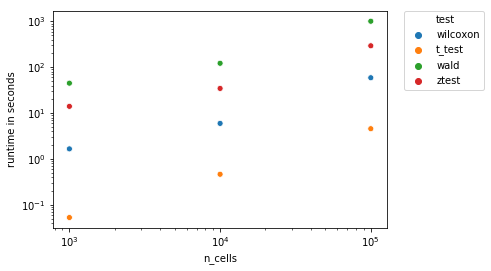

In [5]:
melted = pd.melt(df, id_vars=["n_genes", "n_cells", "n_groups"], var_name="test", value_name="runtime")

fig, ax = plt.subplots()
ax.set(xscale="log", yscale="log")

sns.scatterplot(data=melted, x="n_cells", y="runtime", hue="test", ax=ax)

ax.set(ylabel='runtime in seconds')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()